In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn import preprocessing

%matplotlib inline

def printmd(string):
    display(Markdown(string))

In [2]:
TwoDim = pd.read_csv('TwoDimHard.csv')

display(TwoDim)


,ID,X.1,X.2,cluster
0,1,0.276724,0.793762,1
1,2,0.346407,0.797695,1
2,3,0.296033,0.845381,1
3,4,0.333519,0.774505,1
4,5,0.347625,0.737573,1
5,6,0.443881,0.760030,1
6,7,0.358073,0.736421,1
7,8,0.305019,0.722984,1
8,9,0.235237,0.764224,1
9,10,0.304484,0.720066,1


In [3]:
Two = np.array(TwoDim[['X.1','X.2']])

In [14]:
def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, 9 + n)[9 + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[second_closest_case, ] = case
                replacement_counter += 1
    print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

        


In [7]:
centroids, iterations, clusters = KMeans(4, Two)
(TwoDim.cluster == clusters).value_counts()

False    214
True     186
Name: cluster, dtype: int64

In [8]:
clusters

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 2,
       3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

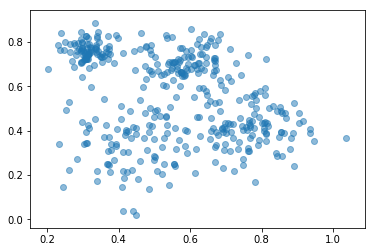

In [9]:
plt.scatter(Two[:,0], Two[:,1], alpha=0.5)
plt.show()

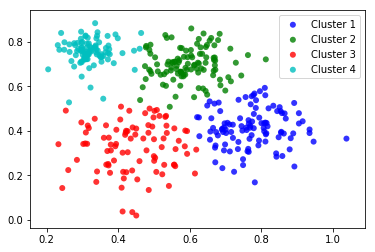

In [10]:
labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)
plt.show()

# True Cluster Membership

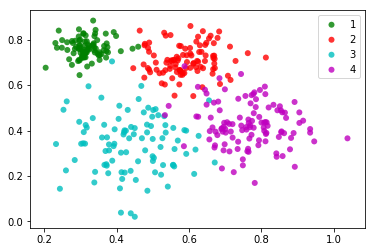

In [11]:
groups = TwoDim.groupby('cluster')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group['X.1'], group['X.2'],alpha=0.8, c=colors[name], edgecolors='none', label=name)
ax.legend()

plt.show()

# Wine Data Clustering

In [12]:
wine = pd.read_csv('winequality-red.csv', sep = ';')
Wine_Base = np.array(wine.drop(columns = ['quality']))
Wine_Norm = preprocessing.normalize(wine.drop(columns = ['quality']))

In [13]:
centroids, iterations, clusters = KMeans(10, Wine_Base)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

Number of iterations : 14
2    1185
5     414
dtype: int64


In [15]:
centroids, iterations, clusters = KMeans(10, Wine_Norm)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

Number of iterations : 12
3    1106
2     493
dtype: int64


In [17]:
cent = reallyreallyInitializeCentroids(Wine_Norm, 10)
_, iterations, clusters = KMeans(10, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

Centroids replaced 61 time(s).
Number of iterations : 24
9     310
2     295
8     219
1     210
7     185
5     154
6     151
3      54
10     20
4       1
dtype: int64


In [19]:
cent = reallyreallyInitializeCentroids(Wine_Base, 10)
_, iterations, clusters = KMeans(10, Wine_Base, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

Centroids replaced 82 time(s).
Number of iterations : 38
1     454
9     381
4     276
10    150
3     119
5      83
6      79
7      46
2       9
8       2
dtype: int64


In [20]:
wine.quality.value_counts()
        

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64